### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

# Solution

### 1. Read in and Plot Data

Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats


# Load the dataset 
data = np.load('../../homeworks/hw_data/hw5_data_1.npy') 

# Extract data
x = data[:, 0] #first column is Time
y = data[:, 1] #Second column is Flux
sigma = data[:, 2] #Second column is uncertainties

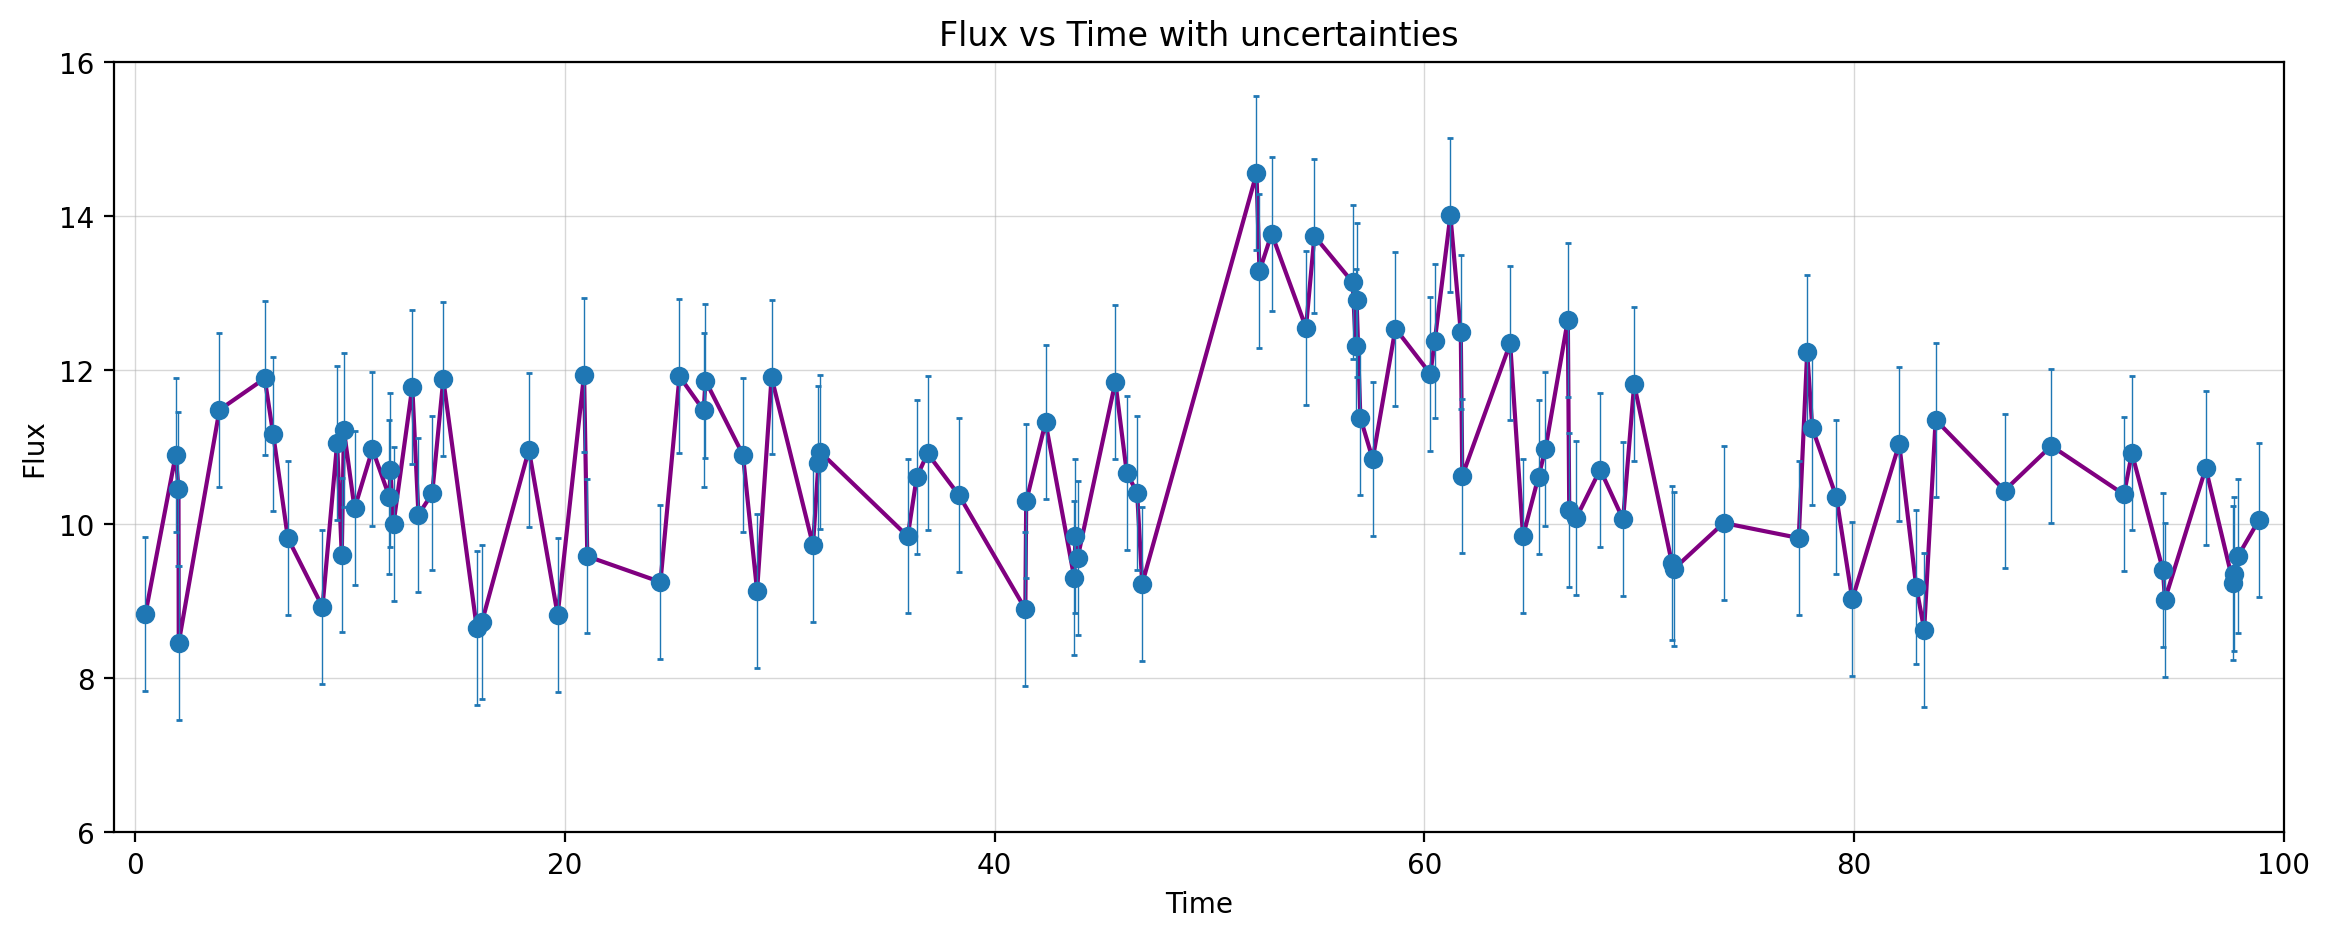

In [3]:
# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(x, y, color='purple')
plt.errorbar(x, y, yerr = sigma,fmt ='o', elinewidth=0.5, capsize=1)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Flux vs Time with uncertainties')
plt.ylim(6,16)
plt.xlim(-1,100)
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.show()

SRT: Good. You can also remove the connecting lines between the data points by adding `fmt='.'` in the arguments for `plt.errorbar`.

### 2. Code Burst model and liklihood function 

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

 For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [4]:
# Code Burst Function

import numpy as np

def Burst_Model(x, b, A, alpha, t0):
    """Burst model for the data"""
    y = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
    return y

In [5]:
# Write the log likelihood function for Burst Model

def log_likelihood(params, x, y, sigma):
    """Log-likelihood for the burst model"""
    b, A, alpha, t0 = params
    y_model = Burst_Model(x, b, A, alpha, t0)
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2)

def log_prior(params):
    b, A, alpha, t0 = params
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < alpha < 5:
        return 0.0  # log(1) for uniform priors within the bounds
    return -np.inf  # log(0) outside the bounds, indicating impossible region


def log_posterior(params, x, y, sigma):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf  # Prior rules out these values
    return lp + log_likelihood(params, x, y, sigma)


SRT: This should work for parameter estimation, but for evidence evaluation it may lead to problems due to the lack of Gaussian likelihood normalization pre-factors. Also, you can scale the way you do the prior function by summing uniform.logpdf calls.

### 3. Bayesian Analysis with MCMC code

Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC.

In [65]:
!pip3 install emcee

In [6]:
import emcee

ndim = 4  # number of parameters in the model
nwalkers = 12  # number of MCMC walkers
burn = 100000  # "burn-in" period to let chains stabilize 100000
nsteps = 4000000  # number of MCMC steps to take **for each walker** #400000

np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,y, sigma))
sampler.run_mcmc(starting_guesses, nsteps);

KeyboardInterrupt: 

### 4. Burn In

Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [7]:
# Calculate the autocorrelation time for each parameter
AC_Time = sampler.get_autocorr_time()
thin=1500

# Discard burn-in steps and thin by the autocorrelation time
samples = sampler.get_chain(discard=burn, thin=thin, flat=True)

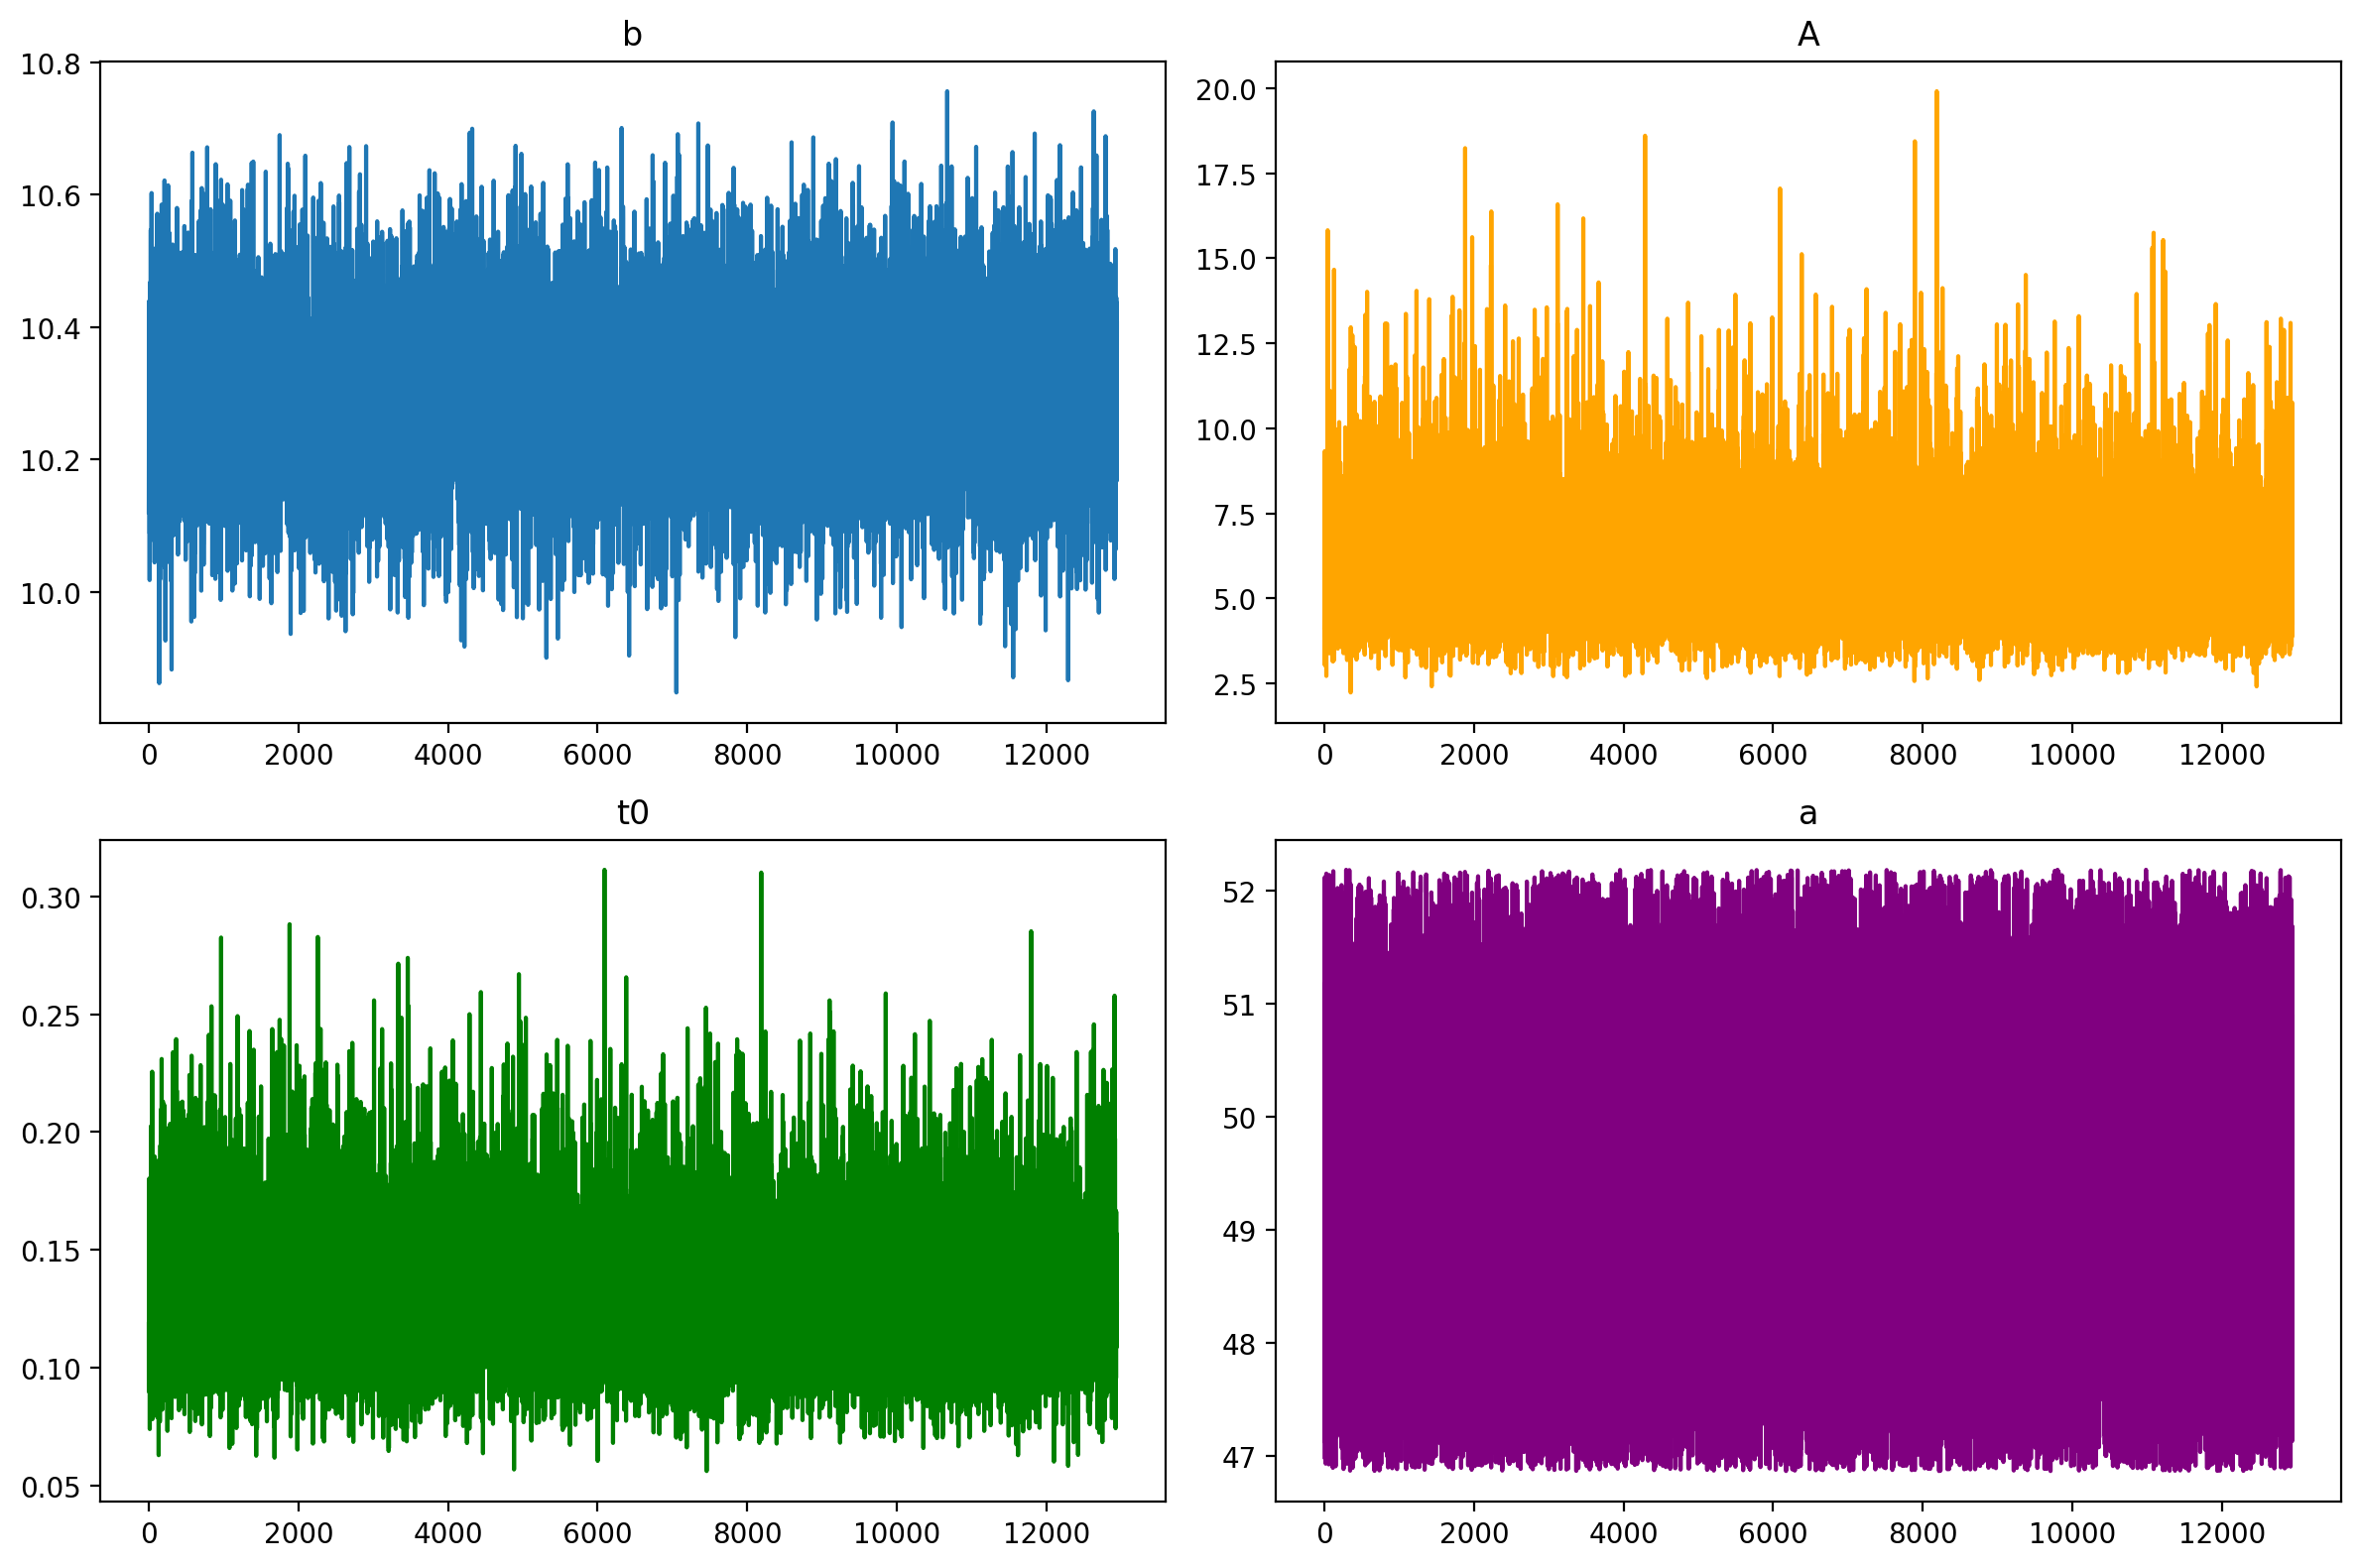

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a samples array with at least 3 features
# samples = your_data_here

# Creating a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot for samples[:,0]
axs[0, 0].plot(samples[:, 0])
axs[0, 0].set_title('b')

# Plot for samples[:,1]
axs[0, 1].plot(samples[:, 1], color='orange')
axs[0, 1].set_title('A')

# Plot for samples[:,2]
axs[1, 0].plot(samples[:, 2], color='green')
axs[1, 0].set_title('t0')

# Plot for samples[:,3]
axs[1, 1].plot(samples[:, 3], color='purple')
axs[1, 1].set_title('a')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### 5. Corner Plot

Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

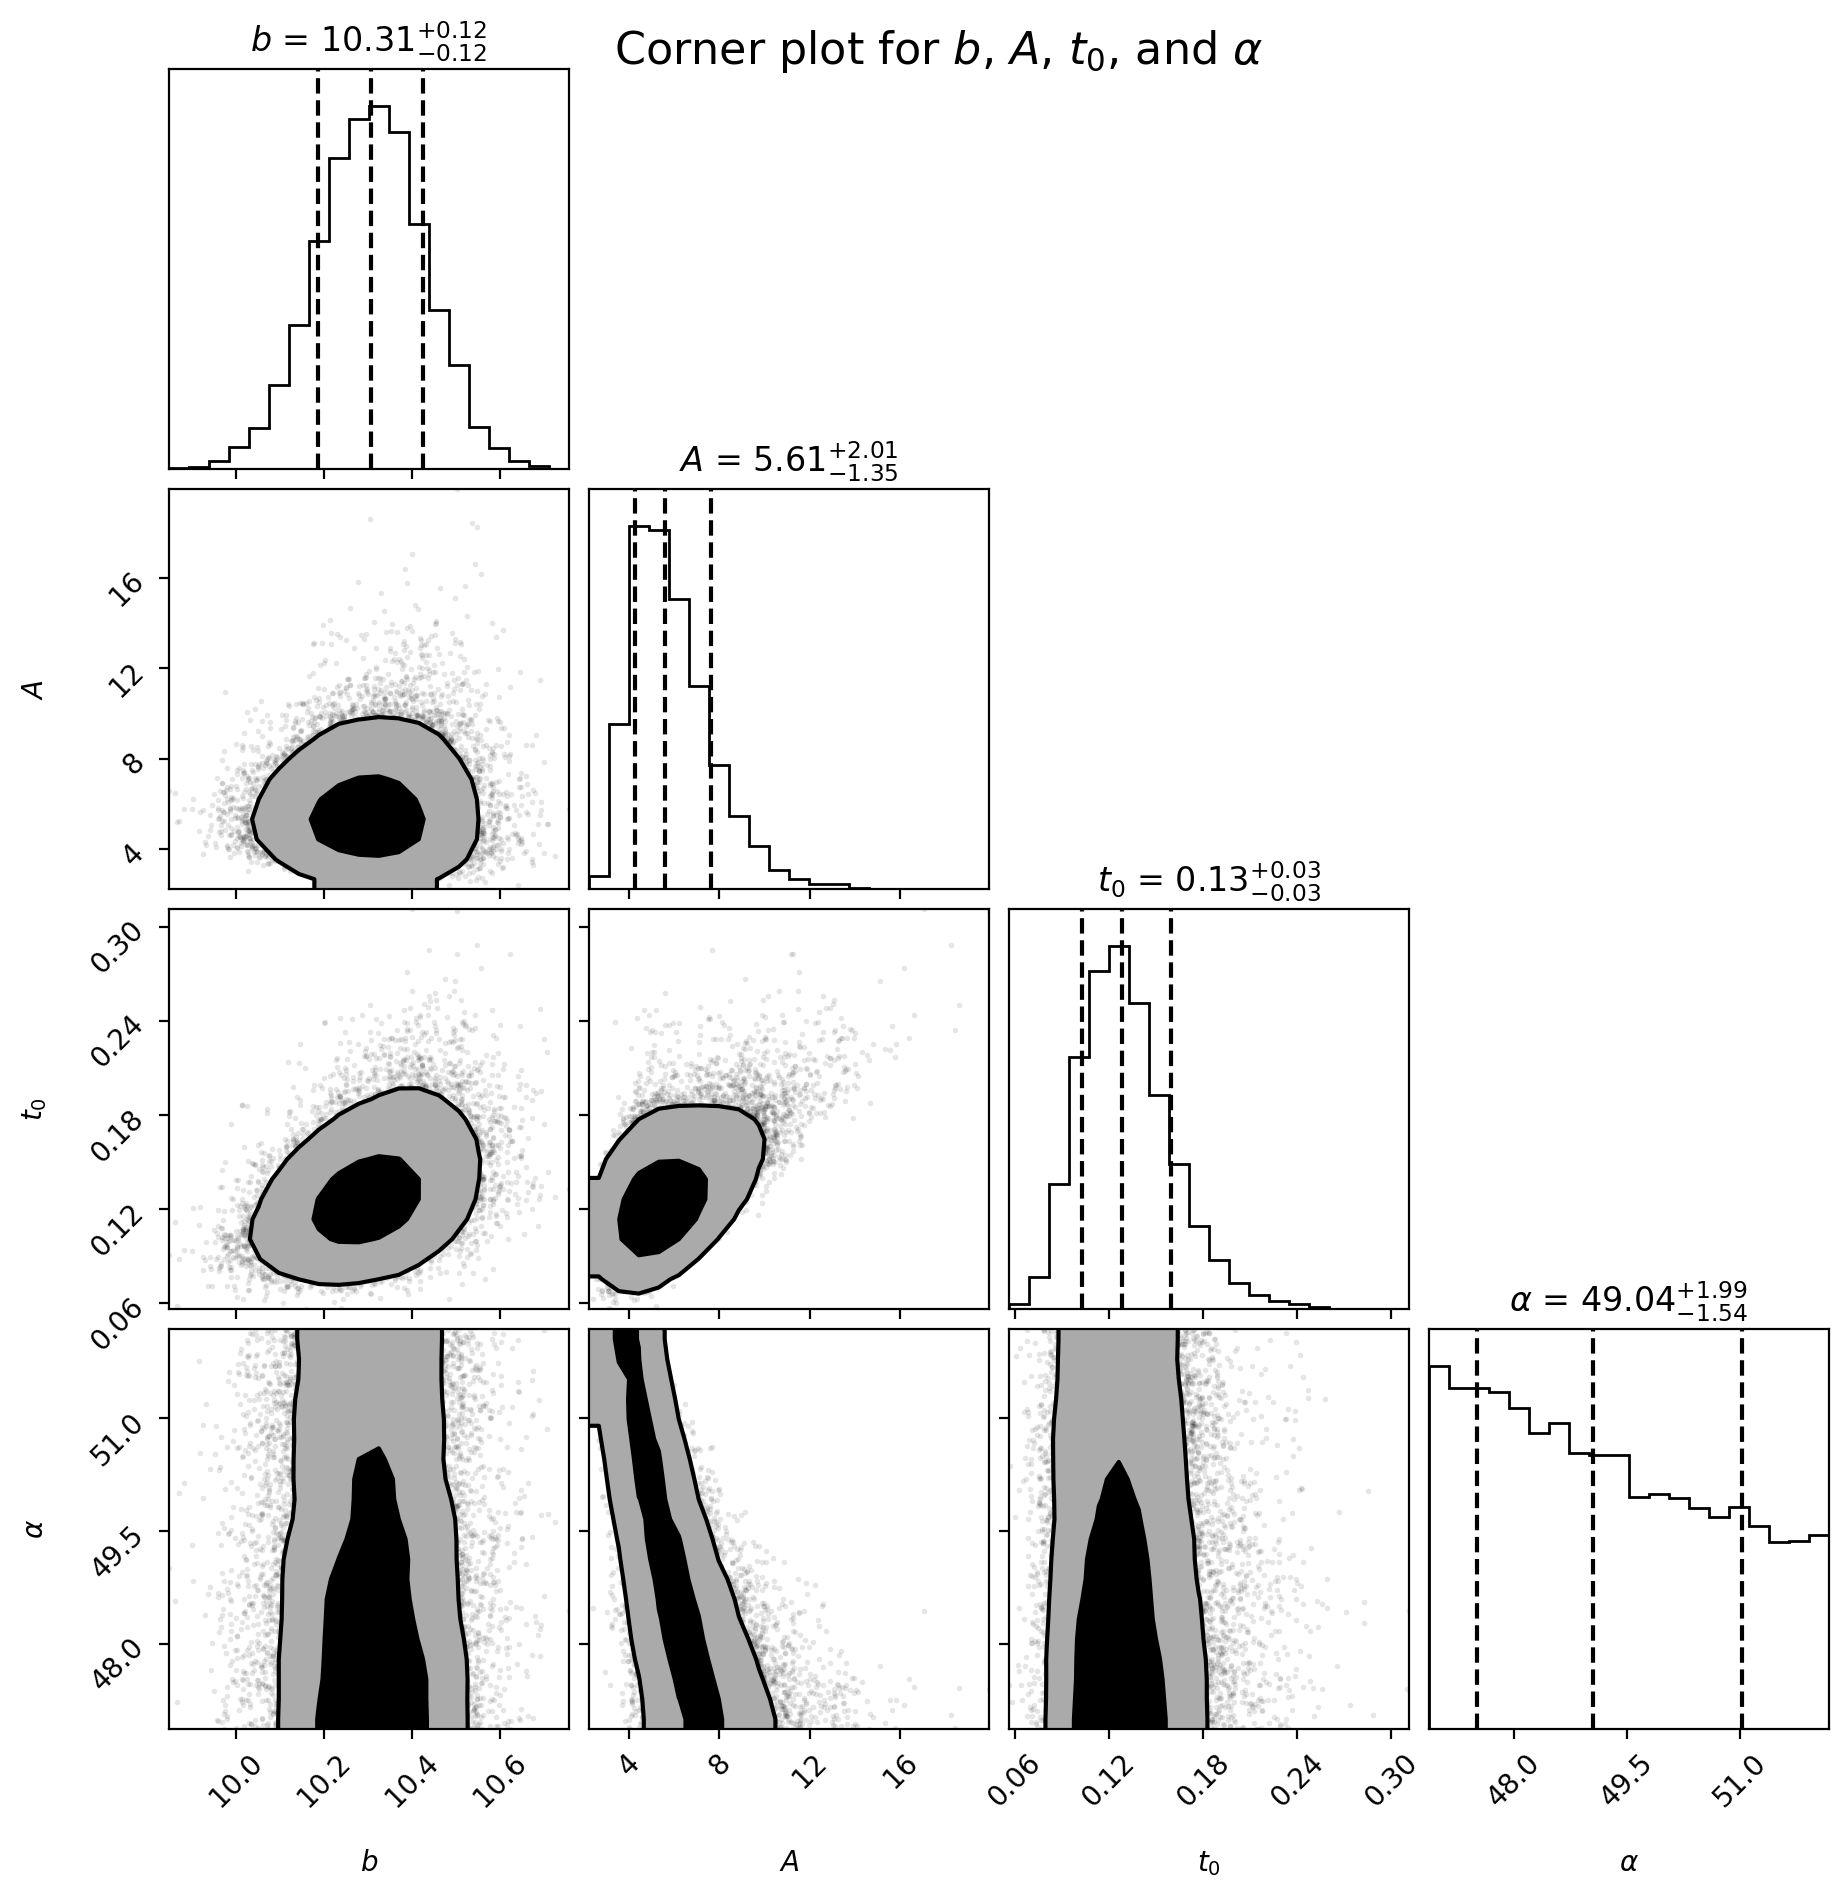

In [9]:
# Create corner plot

import corner

figure = corner.corner(samples, labels=[r'$b$', r'$A$', r'$t_0$', r'$\alpha$'],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       levels=(1-np.exp(-0.5), 1-np.exp(-2)),  # 68%, 95% credible levels
                       plot_datapoints=True, fill_contours=True, smooth=1.0)

figure.suptitle('Corner plot for $b$, $A$, $t_0$, and $\\alpha$', fontsize=16)
plt.show()


SRT: Good, with just a few small problems. The levels should just be 0.68 and 0.95. The labels are also out of order. -2 points.

### 6. Random Samples

 Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

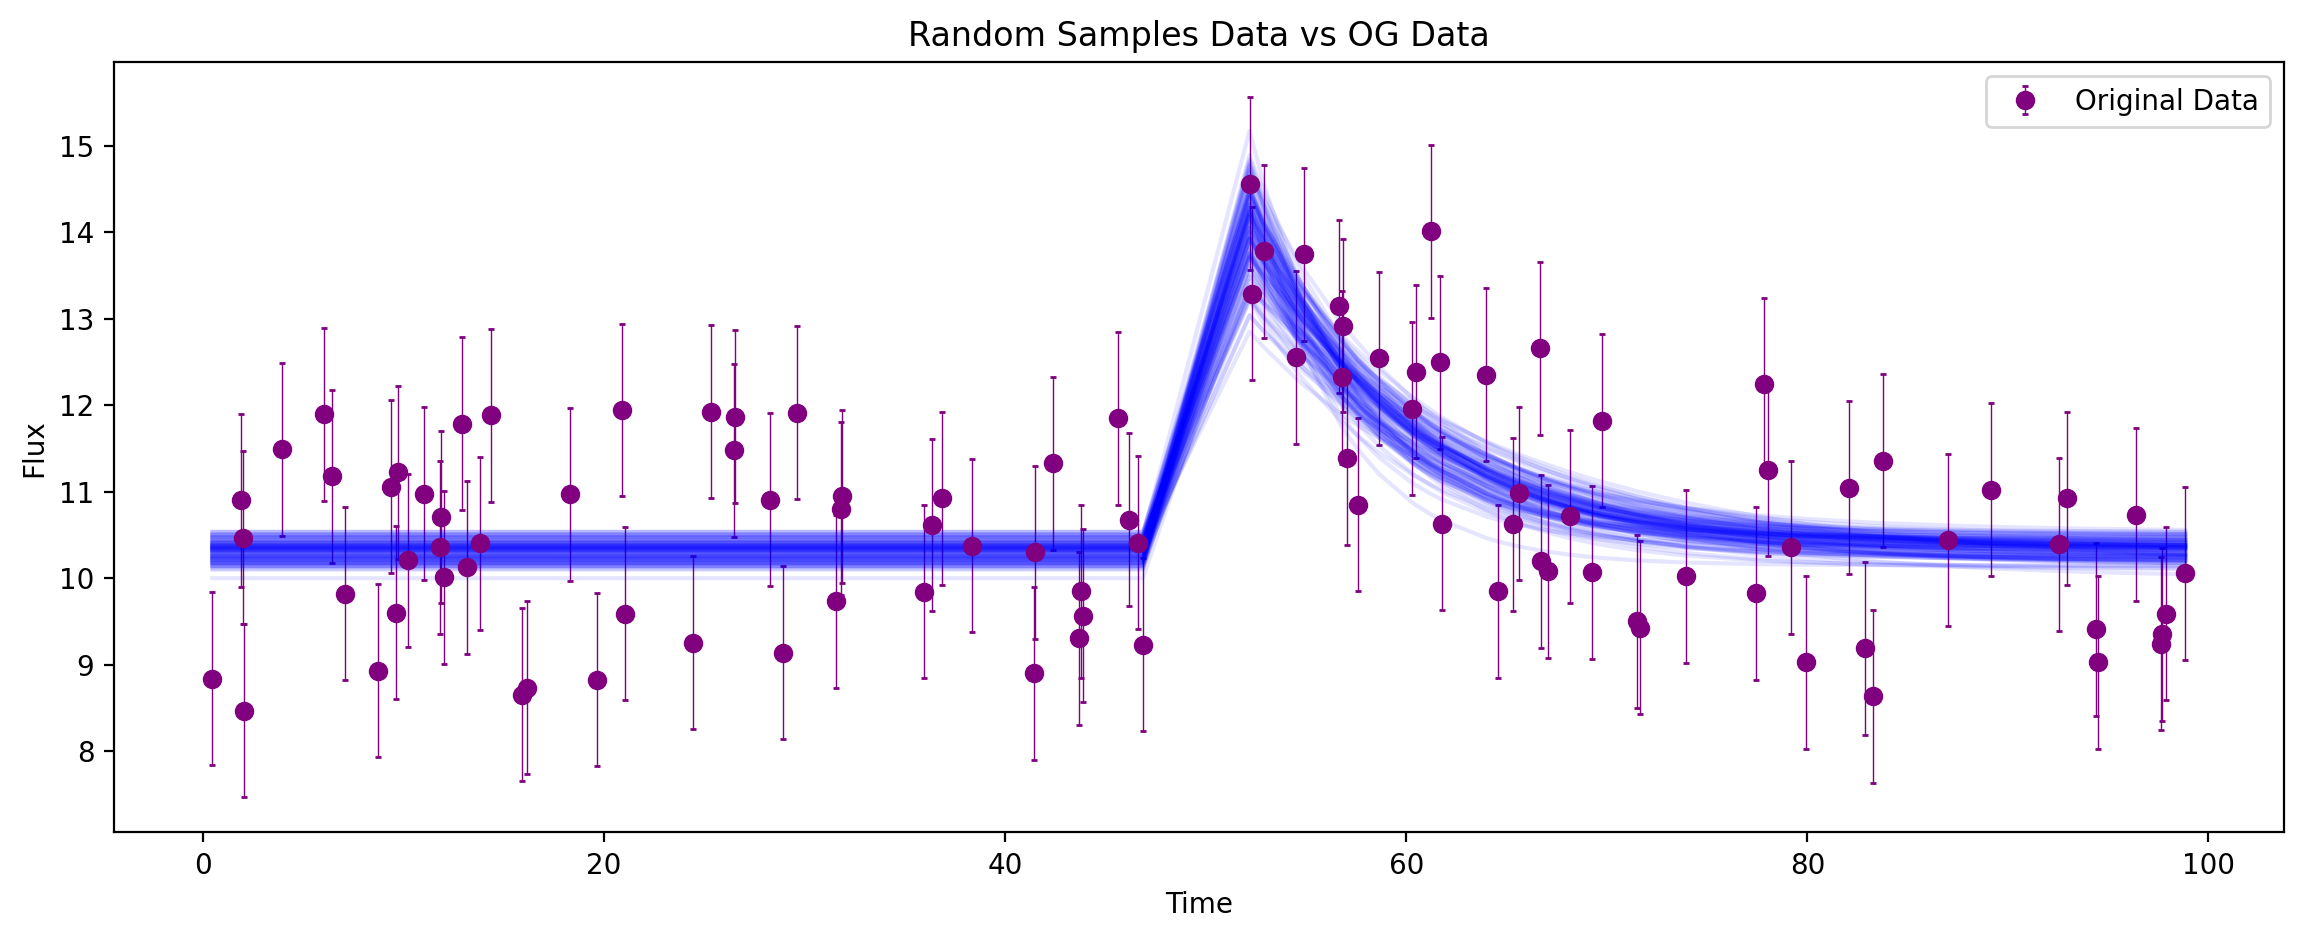

In [10]:
random_indices = np.random.choice(samples.shape[0], 100, replace=False) #replace being false means we only take an element once
random_samples = samples[random_indices, :]

plt.figure(figsize=(14, 5))

# Plot the original data
plt.errorbar(x, y, yerr=sigma, fmt='o', color='purple', elinewidth=0.5, capsize=1, label='Original Data')

# Loop over 100 samples for each parameter
for i in range(100):
    b, A, t_0, alpha = random_samples[i]
    model_y = Burst_Model(x, b, A, t_0, alpha)
    plt.plot(x, model_y, color='blue', alpha=0.1)  # low alpha for transparency

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Random Samples Data vs OG Data')
plt.legend()
plt.show()

SRT: Excellent

### 7. 

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

#### 7.1 UltraNest for Gaussian Model

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+01   [-68.2732..-68.2729]*| it/evals=8480/166778 eff=5.0968% N=400   0 0 0 
[ultranest] Likelihood function evaluations: 166832
[ultranest]   logZ = -84.78 +- 0.1576
[ultranest] Effective samples strategy satisfied (ESS = 2940.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.


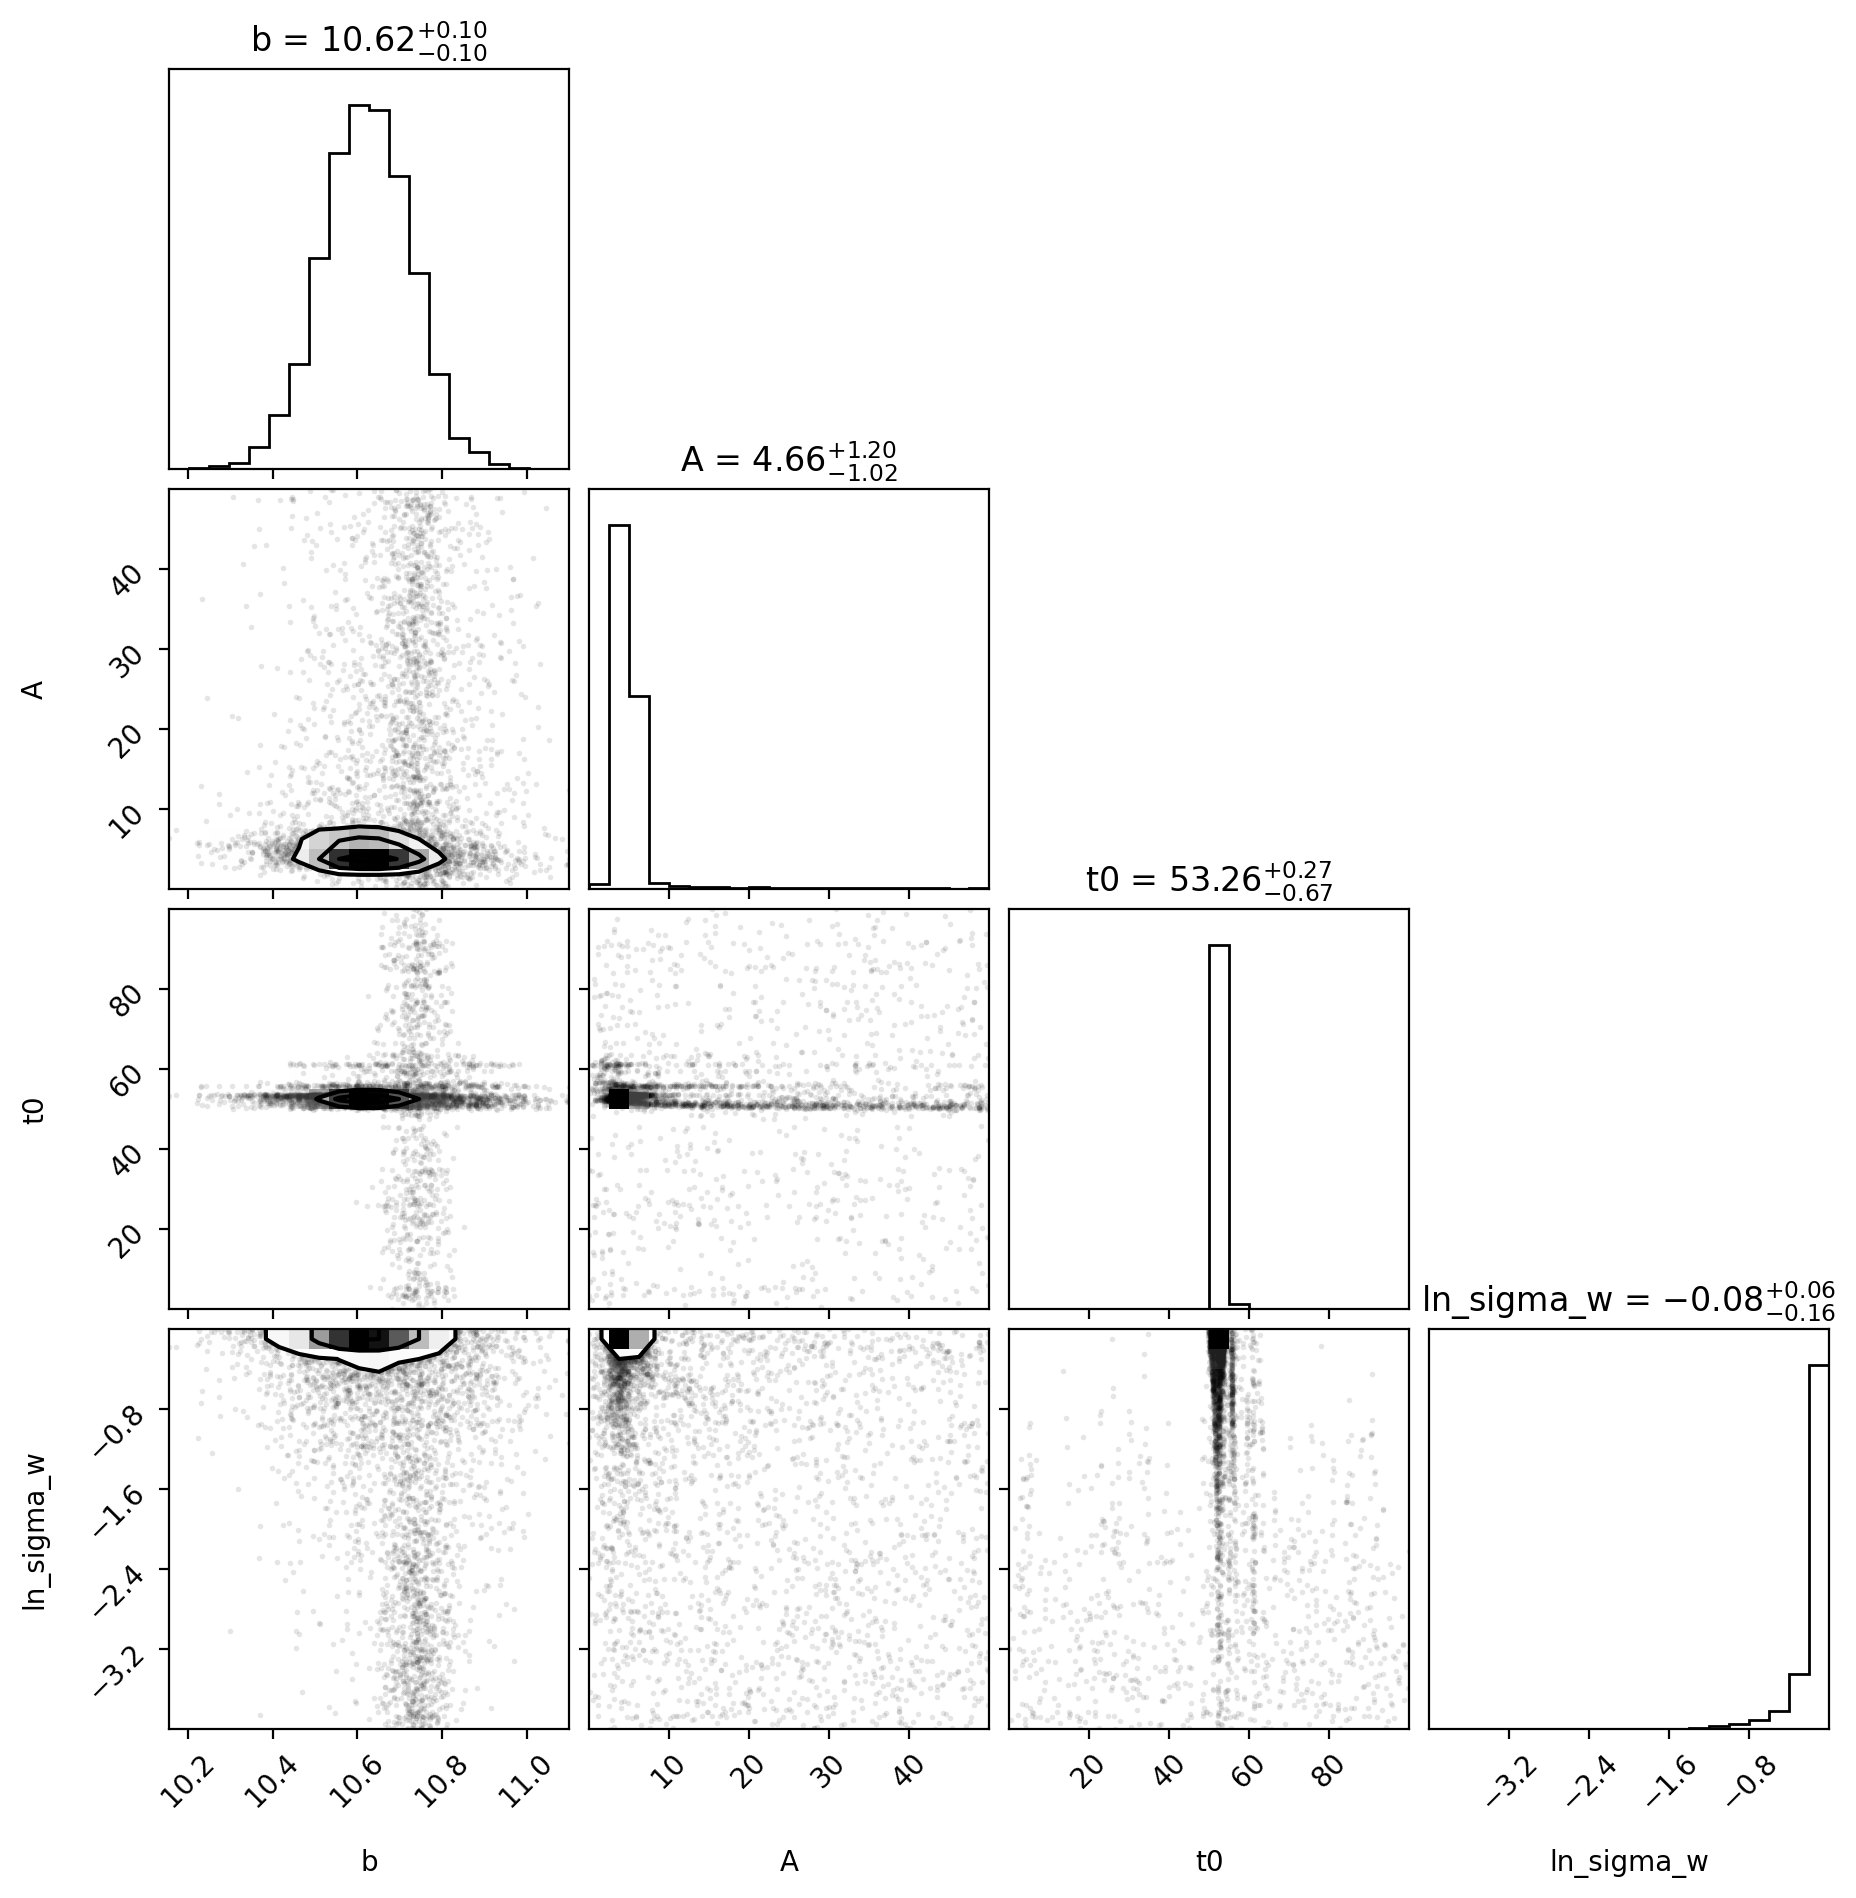

In [11]:
import ultranest

param_names = ['b', 'A', 't0', 'ln_sigma_w']

def my_prior_transform(cube):
    params = cube.copy()
    # Uniform priors transformation
    params[0] = cube[0] * 50  # b
    params[1] = cube[1] * 50  # A
    params[2] = cube[2] * 100  # t0
    params[3] = cube[3] * -4  # ln (sigma)
    return params

def my_likelihood(params):
    b, A, t0, ln_sigma_w = params
    sigma_w = np.exp(ln_sigma_w)  # Convert back to sigma
    y_model = b + A * np.exp( -((x - t0)**2 ) / (2 * ((sigma_w)**2)))
    # Gaussian likelihood
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2)

#Do nested sampling run 
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)
result = sampler.run(min_num_live_points=400)


from ultranest.plot import cornerplot, runplot

cornerplot(result)

SRT: There's a problem with your transformation of the unit variable to log sigma. At the moment, your transformation converts to the range [-4,0]. You needed to add an offset to get it [-2,2]. -2 points.

#### 7.2 UltraNest for OG Model

[ultranest] Sampling 400 live points from prior ...


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gd

/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gd

/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gd

/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gd

/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in exp
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_41639/2558852594.py:15: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))


[ultranest] Explored until L=-7e+01   [-70.8730..-70.8730]*| it/evals=7400/100473 eff=7.3946% N=400 
[ultranest] Likelihood function evaluations: 101020
[ultranest]   logZ = -84.79 +- 0.1068
[ultranest] Effective samples strategy satisfied (ESS = 2239.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.


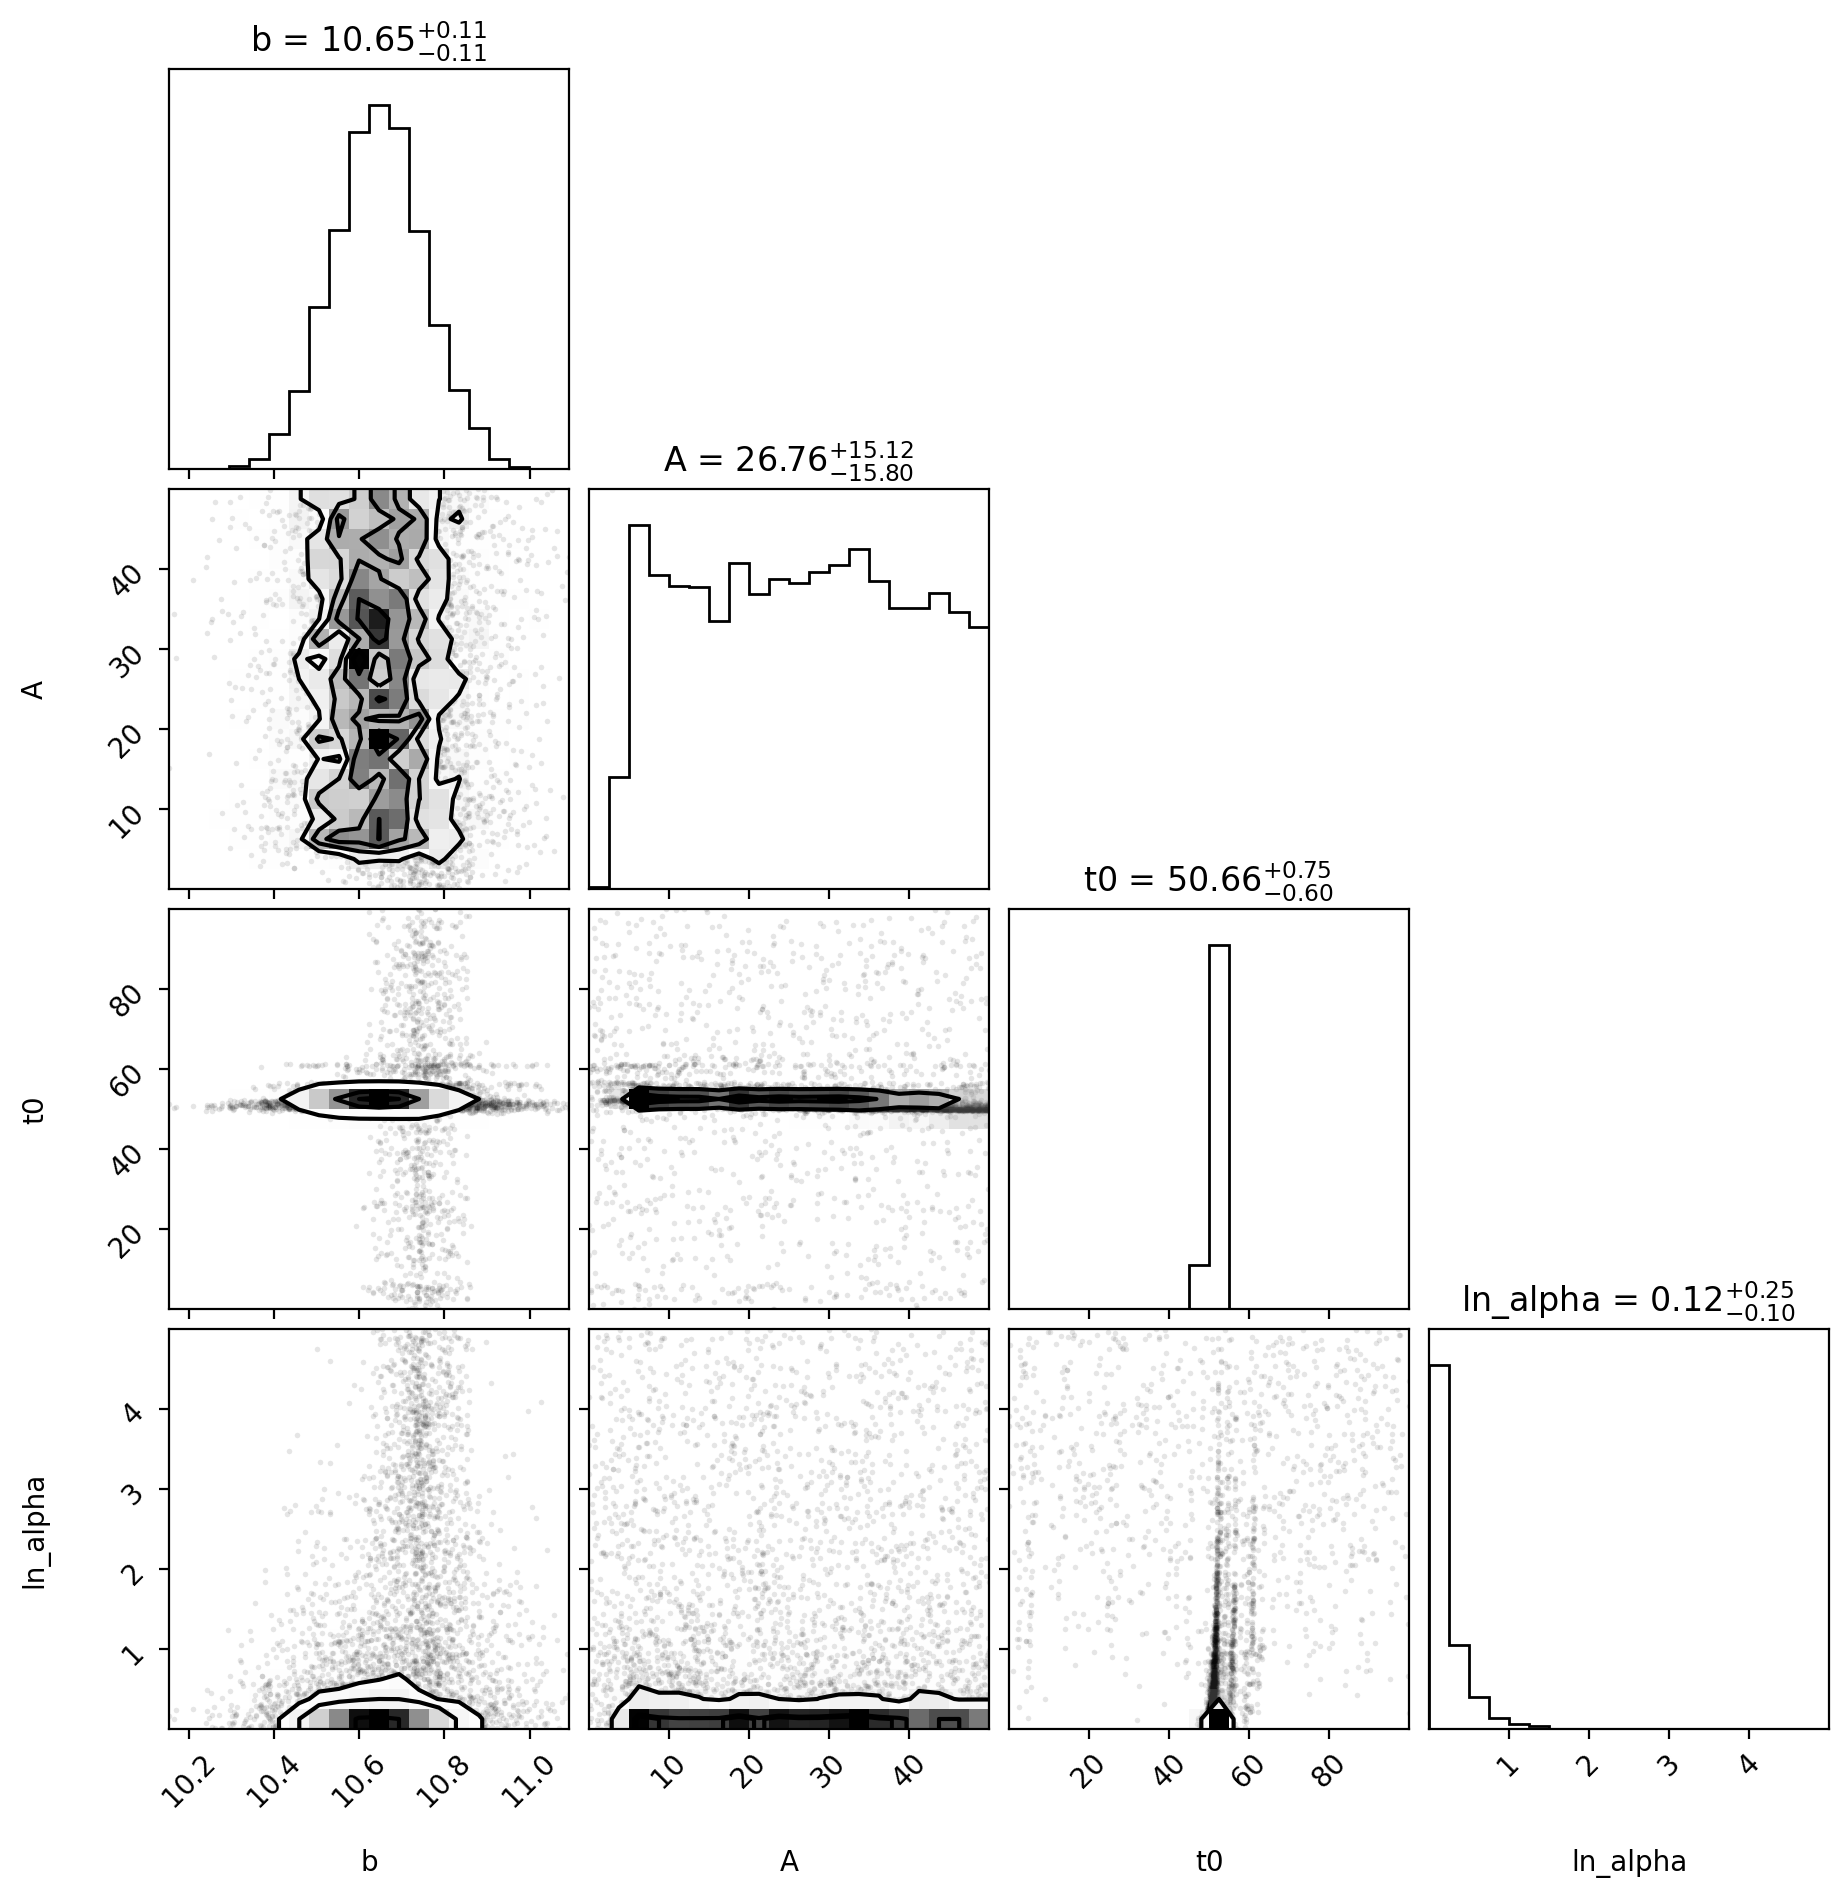

In [12]:
param_names = ['b', 'A', 't0', 'ln_alpha']

def my_prior_transform(cube):
    params = cube.copy()
    # Uniform priors transformation
    params[0] = cube[0] * 50  # b
    params[1] = cube[1] * 50  # A
    params[2] = cube[2] * 100  # t0
    params[3] = cube[3] *  5  # ln alpha
    return params

def my_likelihood(params):
    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)  # Convert back to sigma
    y_model = np.where(x < t0, b, b + A * np.exp(-alpha * (x - t0)))
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2)

#Do nested sampling run 
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)
result2 = sampler.run(min_num_live_points=400)


cornerplot(result2)

SRT: The problem now is the transformation for the log alpha parameter, which you have in the range [0,5] instead of [-5,5]. -2 points.

In [13]:
log_evidence_model_1 = result2['logz']  # From the burst model
log_evidence_model_2 = result['logz']  # From the Gaussian model

print, log_evidence_model_1, log_evidence_model_2

(<function print(*args, sep=' ', end='\n', file=None, flush=False)>,
 -84.7951615134418,
 -84.82558821314002)

In [14]:
#Compute the Bayes factor, and state which model is the favored description of the data

BayesFactor = log_evidence_model_1 - log_evidence_model_2

print(f"Bayes Factor of Model 1 vs Model 2): {BayesFactor}")
if BayesFactor > 0:
    print("Model 1 (Burst Model) is favored.")
else:
    print("Model 2 (Gaussian Model) is favored.")

Bayes Factor of Model 1 vs Model 2): 0.03042669969822498
Model 1 (Burst Model) is favored.


SRT: This is technically the log Bayes factor, but you are correct that according to this definition, if positive it favors the burst model.